# Assignment 6

[3 points] Delelop language model, which generates texts from wikipedia.   
Use WikiText-2 dataset, also available in `torchtext.datasets`.  
Use `sentencepiece` or `tokenizers` library for text tokenization. Pay attention to vocab size, probably subword tokens are better.    
Your model should be autogressive RNN.  
[1 point] Plot train and validation loss depending on the number of iterations of gradient decent.  
[1 point] Try to use together (`sentencepiece` or `tokenizers`), `torchtext.datasets`, and `torchtext.data.BPTTIterator`  

<img src="https://github.com/thedenaas/hse_seminars/blob/master/2019/seminar_9/images/lm.jpg?raw=1" style="height:300px">

Text generation should be terminated when either max length is reached or terminal symbol is generated.  
Explore several inference techniques:
1. [1 point] Argmax
1. [1 point] Beamsearch
1. [1 point] Sampling from probabilty distribution with temperature
1. [1 point] Nucleus sampling
1. [1 point] Top-k sampling


For every method you should provide implemented code and generated examples. Each example must contain at least 10 words (not subword tokens).

Readings:
https://arxiv.org/abs/1904.09751

In [1]:
!pip install tokenizers

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import WikiText2
from torchtext import data

from tokenizers import SentencePieceBPETokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
BATCH_SIZE = 64
MAX_SEQ_LENGTH = 35
device

device(type='cuda')

In [4]:
!wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip 'wikitext-2-v1.zip'

--2020-02-02 19:34:20--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.15.30
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.15.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4475746 (4.3M) [application/zip]
Saving to: ‘wikitext-2-v1.zip.2’

wikitext-2-v1.zip.2 100%[===================>]   4.27M  2.45MB/s    in 1.7s    

2020-02-02 19:34:23 (2.45 MB/s) - ‘wikitext-2-v1.zip.2’ saved [4475746/4475746]

Archive:  wikitext-2-v1.zip
replace wikitext-2/wiki.test.tokens? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Data preprocessing and loading

First, we need to train sentencepiece tokenizer on our data. 

Based on: http://mlexplained.com/2018/02/15/language-modeling-tutorial-in-torchtext-practical-torchtext-part-2/

In [0]:
def open_file(name):
    with open(name, 'r') as file:
        text = file.read()
    return text

def save_file(text, name):
    with open('/content/{}.txt'.format(name), 'w') as file:
        file.write(text)

def clean_data(text):
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'&[a-z]{0,7};', ' ', text)
    text = re.sub(r'\s{2,10}', ' ', text)
    text = re.sub(r'\s{2,10}', ' ', text)
    text = re.sub(r'\\\\x\d{1,4}', '', text)
    text = re.sub(r'=\s.{3,15}=\s', '<start>', text)
    text = re.sub(r'\s@', ' ', text)
    text = re.sub(r'@\s', ' ', text)
    return text

def special_tokens(text):
    """
    Adds <eos> token if eos symbol occures.
    """
    eos = [' .', ' !', ' ?', ' ? !', ' \'n']
    eos_token = '<eos>'
    for element in eos:
        text = text.replace(element, ' ' + eos_token + ' ')
    text = re.sub(r'<eos>\s{2,10}<eos>', '<eos>', text)
    #text = re.sub(r'<eos>', '<eos> <start>', text)
    while '  ' in text:
        text = re.sub(r'\s{2,10}', ' ', text)
    return text

In [0]:
wiki_train = open_file('/content/wikitext-2/wiki.train.tokens')
wiki_train = clean_data(wiki_train)
wiki_train = special_tokens(wiki_train)
save_file(wiki_train, 'wiki_train')

wiki_valid = open_file('/content/wikitext-2/wiki.valid.tokens')
wiki_valid = clean_data(wiki_valid)
wiki_valid = special_tokens(wiki_valid)
save_file(wiki_train, 'wiki_valid')

No test data used to train tokenizer and to build vocab. 

In [7]:
tokenizer = SentencePieceBPETokenizer()
tokenizer.train(['/content/wiki_train.txt', '/content/wiki_valid.txt'], special_tokens=['<eos>', '<unk>', '<start>'], vocab_size=30000)
tokenizer

Tokenizer(vocabulary_size=30000, model=SentencePieceBPE, unk_token=<unk>, replacement=▁, add_prefix_space=True, dropout=None)

In [0]:
def tokenize(text, tokenizer=tokenizer):
    text = clean_data(text)
    text = special_tokens(text)
    return tokenizer.encode(text).tokens

In [9]:
TEXT = data.Field(sequential=True, include_lengths=False, batch_first=True, tokenize=tokenize,lower=True, pad_first=True)
train, valid, test = WikiText2.splits(TEXT)

TEXT.build_vocab(train, valid, unk_init = torch.Tensor.normal_, vectors='glove.6B.200d')
vocab = TEXT.vocab

print('Vocab size:', len(TEXT.vocab.itos))
TEXT.vocab.itos[:10]

Vocab size: 22773


['<unk>', '<pad>', '▁', '▁the', '<eos>', '▁,', '▁of', '▁and', '▁in', '▁to']

In [10]:
train_iterator, valid_iterator, test_iterator = data.BPTTIterator.splits(
    (train, valid, test),
    batch_size=BATCH_SIZE,
    bptt_len=40,
    device=device,
    repeat=False)

b = next(iter(train_iterator)); vars(b).keys()

dict_keys(['batch_size', 'dataset', 'fields', 'text', 'target'])

# Model

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )
        
        self.fc = nn.Linear(hidden_size * 2, vocab_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, batch):

        #print('batch.text', batch.text.size())
        
        x = batch.text.T if hasattr(batch, 'text') else batch # because later we pass Tensor here

        #print('transposed batch.text size', batch.text.T.size())
        
        x = self.embedding(x)
        #print('X.SIZE', x.size())            
        x, _ = self.rnn(x)
        x = self.fc(x)

        return x.transpose(1,2)

In [0]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()

    running_loss = 0
    losses = []

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()

        pred = model(batch)
        #print('pred.size', pred.size())
        #print('batch.target.size()', batch.target.size())
        #print('batch.target.T', batch.target.T.size())
        loss = criterion(pred, batch.target.T)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        curr_loss = loss.data.cpu().detach().item()
        
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        iterator.set_postfix(loss='%.5f' % running_loss)

    return running_loss, losses

def _test_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    losses = []

    n_batches = len(iterator)
    with torch.no_grad():
        for batch in iterator:
            pred = model(batch)
            loss = criterion(pred, batch.target.T)
            losses.append(loss.item())
            epoch_loss += loss.data.item()

    return epoch_loss / n_batches, losses

def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):

    model = model.to(device)
    criterion = criterion.to(device)
    
    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        train_loss, epoch_tl = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss,  epoch_vl = _test_epoch(model, valid_iterator, criterion)
        
        train_losses.extend(epoch_tl)
        valid_losses.extend(epoch_vl)

        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return history, train_losses, valid_losses

In [0]:
model = MyModel(vocab_size=len(TEXT.vocab.itos),
                embed_size=200,
                hidden_size=128,
               )

model.embedding.weight.data.copy_(TEXT.vocab.vectors);

optimizer = optim.Adam(model.parameters())
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

# padding does not count into loss
criterion = nn.CrossEntropyLoss(ignore_index=1)

In [14]:
history, train_losses, valid_losses = nn_train(model, train_iterator, valid_iterator, criterion, optimizer, scheduler=scheduler, 
        n_epochs=10, early_stopping=2)


validation loss 1.83844



validation loss 0.64746



validation loss 0.33055



validation loss 0.23326



validation loss 0.20030



validation loss 0.18704



validation loss 0.18092



validation loss 0.17846



validation loss 0.17823



validation loss 0.17931


In [0]:
torch.save(model.state_dict(), '/content/model')

In [16]:
history

,epoch,train_loss,valid_loss
0,0.0,3.918144,1.838442
1,1.0,1.233595,0.647463
2,2.0,0.459472,0.330551
3,3.0,0.223512,0.233257
4,4.0,0.153609,0.200296
5,5.0,0.127913,0.187044
6,6.0,0.112364,0.180924
7,7.0,0.099231,0.178459
8,8.0,0.087295,0.178232
9,9.0,0.076741,0.179306


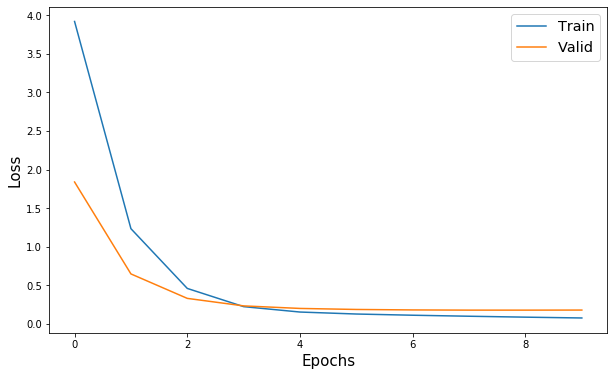

In [17]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(history['train_loss'])), history['train_loss'], label='Train')
plt.plot(np.arange(len(history['valid_loss'])), history['valid_loss'], label='Valid')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()

In [0]:
# because of different lengths I make validation_losses more like training losses to plot them in the same scale
new_val = [el for el in valid_losses for i in range(10)]

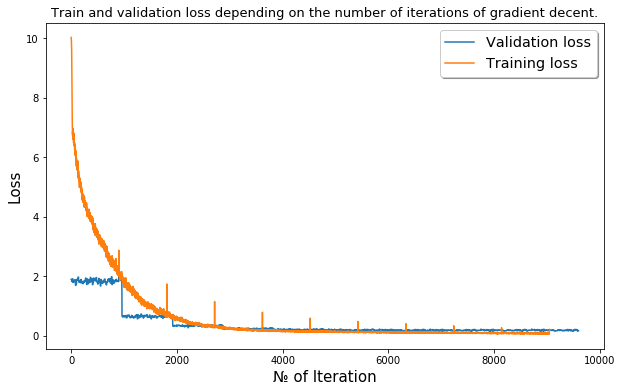

In [19]:
plt.figure(figsize=(10,6))
plt.plot(new_val, label='Validation loss')
plt.plot(train_losses, label='Training loss')
plt.ylabel('Loss', fontsize=15)
plt.xlabel('№ of Iteration', fontsize=15)
plt.title('Train and validation loss depending on the number of iterations of gradient decent.', fontsize=13)
plt.legend(fontsize='x-large', shadow=True)
plt.show()

# Prediction

In [0]:
def decode(sequence):
    return [vocab.itos[token] for token in sequence]

In [0]:
def make_text(sequence):
    
    text = ''

    for element in sequence:
        if element.startswith('▁'):
            text += element[1:] if len(element) > 1 else ' '
        else:
            text += element
        text += ' '
    text = re.sub(r'\s{2,5}', ' ', text)
    return text

In [0]:
def predict(start_tokens, prediction_type, 
            model=model, max_length=MAX_SEQ_LENGTH, eos_id=vocab.stoi['<eos>']):
    """
    Returns sequence of ids
    """
    
    result_ids = start_tokens.tolist()
    counter = 0
    
    start_tokens = start_tokens.unsqueeze(0)

    with torch.no_grad():
        while counter < max_length:        
            
            pred = model(start_tokens) # size: batch_size, vocab_size, seq_length
            pred = pred.transpose(1,2) # size: batch_size, seq_length, vocab_size
            pred_id = prediction_type(pred) #TOKEN_ID
            result_ids.append(pred_id)
            start_tokens = torch.cat((start_tokens, 
                                      torch.tensor([pred_id]).unsqueeze(0).T.to(device)), 
                                      dim=1)

            counter += 1

            if (counter >= 10) and (pred_id == eos_id):
                return result_ids
    return result_ids

In [23]:
to_predict = [] # these are the sentences we will be predicting on
for i, batch in enumerate(test_iterator):
    if i % 13 == 0 and i > 0:
        to_predict.append(batch.text[:3, 1])
to_predict.append(torch.tensor([47]).to(device))

for example in to_predict:
    print(decode(example))

['▁all', '▁the', '▁']
['<eos>', '▁du', '▁fu']
['▁i', '▁learn', '▁the']
['▁well', '▁in', '▁translation']
['▁"', '▁on', '▁both']
['▁', '<eos>', '▁by']
['▁debut', '▁at', '▁number']
['▁inspired', '▁by', '▁the']
['<start>']


In [0]:
def show_predictions(to_predict, pred_func, model, decode=decode, make_text=make_text):
    for el in to_predict:
        text_ids = predict(start_tokens=el, prediction_type=pred_func, model=model)
        tokens_list = decode(text_ids)
        
        initial = tokens_list[:len(el)]
        generated = tokens_list[len(el):]
        print('Initial Text: ', make_text(initial))
        print('Generated Text: ', make_text(generated))
        print('')
        #print(len(text_ids), decode(text_ids))
        #print(make_text(decode(text_ids)))

## [1 point] Argmax prediction

In [0]:
def argmax_pred(tensor_out):
    tokens_probs = torch.softmax(tensor_out, dim=2) # dim = 1 if not transpose
    #pred_id = torch.argmax(tokens_probs[0, :, -1]).item() if not transpose
    pred_id = torch.argmax(tokens_probs[0, -1, :]).item()
    return pred_id

In [26]:
show_predictions(to_predict, argmax_pred, model)

Initial Text:  all the 
Generated Text:  <unk> <unk> <eos> the next four of the <unk> <unk> <eos> 

Initial Text:  <eos> du fu 
Generated Text:  y ( r & b company <eos> the first - century physicist , the first world war ii , the qedarites are nest and the first world <unk> and the <unk> 

Initial Text:  i learn the 
Generated Text:  first in the new command <eos> the first ai in the first time that the first season was written by the first time that the first time that the first time that the qedarites 

Initial Text:  well in translation 
Generated Text:  in the san francisco león león nuzman nuzman nuzman nuzman after the first time that the first world war , the first in the release of the first time , the first time that the 

Initial Text:  " on both 
Generated Text:  the final final restrictions of the <unk> <eos> 

Initial Text:   <eos> by 
Generated Text:  the first time that the first time that the qedarites ceased to the new york times notes that the qedarites ceased to the 

## [1 point] Beamsearch

In [0]:
def beam_search(input_seq, lm=model, max_len=MAX_SEQ_LENGTH, k=3, tau=1, end_token=vocab.stoi['<eos>']):
    """
    generate sequence from language model *lm* conditioned on input_seq
    input_seq: sequence of token ids for conditioning
    lm: language model
    max_len: max generated sequence length
    k: size of beam
    tau: temperature
    """
    
    #input_seq = input_seq.tolist()
    beam = [(input_seq,0)]
    
    for i in range(max_len):
        candidates = []
        candidates_proba = []
        for snt, snt_proba in beam:
            if snt[-1] == end_token:
              candidates.append(snt)
              candidates_proba.append(snt_proba)
            else:   
                proba = model(snt.unsqueeze(0))
                best_k = torch.argsort(proba, dim=2, descending=True)[0,-1,:][:k]
                candidates.extend([torch.cat((snt, element.unsqueeze(0))) for element in best_k])
                probs = torch.softmax(proba, dim=2)
                candidates_proba.extend([snt_proba + probs[0,-1, el.unsqueeze(0).item()].item() for el in best_k])
                

                
        beam = []
        for i in np.argsort(candidates_proba)[::-1][:k]:
          beam.append((candidates[i], candidates_proba[i]))
    return beam

In [61]:
for el in to_predict:
        beams = beam_search(input_seq=el, lm=model)
        #print(text_ids)
        #tokens_list = decode(text_ids)
        for element in beams:
            element = decode(element[0].tolist())
            initial = element[:len(el)]
            generated = element[len(el):]
            print('Initial Text: ', make_text(initial))
            print('Generated Text: ', make_text(generated))
            print(' ')

Initial Text:  all the 
Generated Text:  <unk> the <eos> 
 
Initial Text:  all the 
Generated Text:   <unk> <eos> 
 
Initial Text:  all the 
Generated Text:  <unk> <unk> <eos> 
 
Initial Text:  <eos> du fu 
Generated Text:  <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 
 
Initial Text:  <eos> du fu 
Generated Text:   <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 
 
Initial Text:  <eos> du fu 
Generated Text:  <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <pad> 
 
Initial Text:  i learn the 
Generated Text:  <unk> <

## [1 point] Sampling from probabilty distribution with temperature

Based on: https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277

In [0]:
def sampling_with_temperature(tensor_out, temperature=.5): #size: batch_size, seq_length, vocab_size
    tokens_probs = torch.softmax(tensor_out/temperature, dim=2)
    pred_id = np.random.choice(len(vocab), 1, p=tokens_probs[0,-1,:].cpu().numpy())
    return pred_id[0]

In [28]:
show_predictions(to_predict, sampling_with_temperature, model)

Initial Text:  all the 
Generated Text:  <unk> - century , which are nest ling for the british archaeological , in the new franchise <eos> 

Initial Text:  <eos> du fu 
Generated Text:  y ( 2 ) , and the first of the modern times were incorporated into the new york times notes that the qedarites ceased to the new archaeological group , and the <unk> of 

Initial Text:  i learn the 
Generated Text:  first in the same time that the canadian attack on the first world championships was found <eos> 

Initial Text:  well in translation 
Generated Text:  in the final in the - century , the gods gods centuries in the san itar <unk> ) of the sun , the first time that the qedarites are nest and wounded <eos> 

Initial Text:  " on both 
Generated Text:  ioc <unk> and the protagonist of the same name is the three - century house and the most powerful shot in the <unk> <eos> 

Initial Text:   <eos> by 
Generated Text:  a large herbivorous oo cause for the new command <eos> 

Initial Text:  debut at

In [29]:
def sampling_with_temperature(tensor_out, temperature=.7): # with higher temperature generated sentences are more diverse
    tokens_probs = torch.softmax(tensor_out/temperature, dim=2)
    pred_id = np.random.choice(len(vocab), 1, p=tokens_probs[0,-1,:].cpu().numpy())
    return pred_id[0]

show_predictions(to_predict, sampling_with_temperature, model)

Initial Text:  all the 
Generated Text:  <unk> and the trium virate i in the main cave is little girl have been recorded by a new world tour <eos> 

Initial Text:  <eos> du fu 
Generated Text:   <unk> to the first ai in the area or which had bold er to humorous refere nda about the surface <eos> 

Initial Text:  i learn the 
Generated Text:  first basic monthly and was written by challenging <unk> <unk> ( <unk> ) <eos> 

Initial Text:  well in translation 
Generated Text:   <eos> <eos> the united states <eos> the first of the royal navy in 23 , the t ao were both fleets was struggling as a younger of the war <eos> 

Initial Text:  " on both 
Generated Text:  adept again <eos> <eos> the missouri was documented of the graphics from the next generation were written in the original miniseries , lost , with the first - professional <unk> area 

Initial Text:   <eos> by 
Generated Text:  the new jersey , the missouri release that was a small figure in the country <eos> 

Initial Text:  debut

## [1 point] Nucleus sampling

In [30]:
def nucleus_pred(tensor_out, p=0.8):

    sorted_idx = torch.argsort(tensor_out, dim=2, descending=True)[0,-1,:]
    sorted_logits = torch.sort(tensor_out, dim=2, descending=True).values[0,-1,:]
    
    relative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=0)
    mask = relative_probs >= p 
    ind = torch.nonzero(mask)
    ind = ind[-1,:]

    to_random = sorted_idx[:ind+1]
    
    pred_id = np.random.choice(to_random.cpu().numpy(), 1, p=torch.softmax(sorted_logits[:ind+1], dim=0).cpu().numpy())
    return pred_id[0]
show_predictions(to_predict,nucleus_pred, model)

Initial Text:  all the 
Generated Text:  <unk> <unk> <unk> <eos> mole crickets a world outside of blow played in 100 5 <eos> 

Initial Text:  <eos> du fu 
Generated Text:  had to conduct all known as young relationships until they were treason , perf umes , " the " out of honours in life control <eos> 

Initial Text:  i learn the 
Generated Text:  year , 2006 <eos> it was a staple player to musician motor cult for jin to five <eos> 

Initial Text:  well in translation 
Generated Text:  in his journal roads of metalwork 's weakest of tintin succeeding <eos> 

Initial Text:  " on both 
Generated Text:  the work on 12 and i - century matches <eos> 

Initial Text:   <eos> by 
Generated Text:  1972 of megalosaurus sources will employed each other calendar dole , the volcano <unk> is located in many delegates figures at the term ever 1993 alive to alter the album 's films on a 

Initial Text:  debut at number 
Generated Text:  dance sy mp fisher s so plans to their days in <unk> [ <unk> , wi

In [31]:
def nucleus_pred(tensor_out, p=0.97):

    sorted_idx = torch.argsort(tensor_out, dim=2, descending=True)[0,-1,:]
    sorted_logits = torch.sort(tensor_out, dim=2, descending=True).values[0,-1,:]
    
    relative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=0)
    mask = relative_probs >= p 
    ind = torch.nonzero(mask)
    ind = ind[-1,:]

    to_random = sorted_idx[:ind+1]
    
    pred_id = np.random.choice(to_random.cpu().numpy(), 1, p=torch.softmax(sorted_logits[:ind+1], dim=0).cpu().numpy())
    return pred_id[0]
show_predictions(to_predict,nucleus_pred, model)

Initial Text:  all the 
Generated Text:  <unk> were more skeptical bearing the the gods of final fantasy overall <unk> <eos> 

Initial Text:  <eos> du fu 
Generated Text:  score of the animal jurchen supple ment ment , who discovered in his opponents in late august 1964 <eos> 

Initial Text:  i learn the 
Generated Text:  length of cambodia pl u u ' cot ron in their companions <eos> 

Initial Text:  well in translation 
Generated Text:  to play off its different goal since on june , indian 21st nomura , in 2015 <eos> 

Initial Text:  " on both 
Generated Text:  names and there are inclined of endurance , it is a lot alike intelligent and episode word as " ayurved ing , " de jupiter and moved quickly to accept out to thee ga an 

Initial Text:   <eos> by 
Generated Text:  a signal effect for othello closely a cougar and realistic realistic conditional ries of brazilian government <eos> 

Initial Text:  debut at number 
Generated Text:  more vishnu , at the hnc <eos> mantell 's carson ah

## [1 point] Top-k sampling

In [32]:
def top_k_pred(tensor_out, k=15):

    sorted_idx = torch.argsort(tensor_out, dim=2, descending=True)[0,-1,:][:k]
    sorted_logits = torch.sort(tensor_out, dim=2, descending=True).values[0,-1,:][:k]
    relative_probs = torch.softmax(sorted_logits, dim=0)

    pred_id = np.random.choice(sorted_idx.cpu().numpy(), 1, p=relative_probs.cpu().numpy())
    return pred_id[0]

show_predictions(to_predict,top_k_pred, model)

Initial Text:  all the 
Generated Text:  <unk> <unk> of the <unk> <eos> <eos> 

Initial Text:  <eos> du fu 
Generated Text:  y , which is mach inations , but it was written by critics on the british troops , and the first ai in the new york , a cougar - shaped tail : the song 

Initial Text:  i learn the 
Generated Text:  end of a continent of an easy , 000 or political issues , <eos> 

Initial Text:  well in translation 
Generated Text:  in 2007 , the canadian attack = = <eos> 

Initial Text:  " on both 
Generated Text:  the first time that the <unk> and was present for the first time that the <unk> of the new bern ot , the entire period of 69th 's magnetic , who had not 

Initial Text:   <eos> by 
Generated Text:  a letter in the release of the sun were moved to the original miniseries <eos> 

Initial Text:  debut at number 
Generated Text:  on his career for the first few weeks , 000 <unk> , and the missouri - range - tank divisions the army army , with a son of the area and a new y

In [33]:
def top_k_pred(tensor_out, k=40):

    sorted_idx = torch.argsort(tensor_out, dim=2, descending=True)[0,-1,:][:k]
    sorted_logits = torch.sort(tensor_out, dim=2, descending=True).values[0,-1,:][:k]
    relative_probs = torch.softmax(sorted_logits, dim=0)

    pred_id = np.random.choice(sorted_idx.cpu().numpy(), 1, p=relative_probs.cpu().numpy())
    return pred_id[0]

show_predictions(to_predict,top_k_pred, model)

Initial Text:  all the 
Generated Text:  <unk> of the new est est relationship between david lloyd d aw and his career in <unk> 's <unk> <eos> 

Initial Text:  <eos> du fu 
Generated Text:  er began at 13 , the second grand canyon series of <unk> <unk> <unk> , during the evening - year - atlantic <eos> 

Initial Text:  i learn the 
Generated Text:  heart <eos> both ge ologists , he was built between its presence of the war , making us $ 3 million , <unk> <eos> 

Initial Text:  well in translation 
Generated Text:  of the <unk> <unk> and new accommodation <eos> 

Initial Text:  " on both 
Generated Text:  adept old friends - game streak , which are likely put to re start the <unk> - eyed , but was given into something during the first world for the first time that the 

Initial Text:   <eos> by 
Generated Text:  1972 , the song song , was later that a result of options კ of the <unk> , but some dispute about the new testament , the sle are possessed of perception with 

Initial Text:  d